<a href="https://colab.research.google.com/github/JasonWu2020/CompareWeather/blob/main/ECE_239AS_Homework_4_Jason_Wu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE239 Homework 4: Diffusion Models**


Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/) similar to the ones we discussed in class. In this homework, we will use the HuggingFace diffusers library to build a simple Stable Diffusion pipeline and then experiment with different components. At the end, you'll provide a write-up about what worked and what didn't along with some image samples.

A lot of this is based on this notebook: https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb#scrollTo=gd-vX3cavOCt

In [1]:
!nvidia-smi

Wed Dec 13 00:49:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 447.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.1 MB/s eta 0:00:00


### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text.

First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)).

We load the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

In [3]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Next, let's move the pipeline to GPU to have faster inference.

In [4]:
pipe = pipe.to("cuda")

In [5]:
!nvidia-smi

Wed Dec 13 00:50:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |   2793MiB / 15360MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

And we are ready to generate images:

In [6]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

image
pipe = 1
with torch.no_grad():
    torch.cuda.empty_cache()

  0%|          | 0/50 [00:00<?, ?it/s]

Running the above cell multiple times will give you a different image every time. If you want deterministic output you can pass a random seed to the pipeline. Every time you use the same seed you'll have the same image result.

In [7]:
# import torch

# generator = torch.Generator("cuda").manual_seed(1024)

# image = pipe(prompt, generator=generator).images[0]

# image

We can change the number of denoising steps using the ``num_inference_steps`` parameter. Generally, increasing the step count will generate higher quality images but will take longer while lower step counts could generate worse looking or more incoherent images.

In [8]:
# import torch

# generator = torch.Generator("cuda").manual_seed(1024)

# image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]

# image

The other parameter in the pipeline call is `guidance_scale`. It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. In simple terms classifier free guidance forces the generation to better match with the prompt. Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse.

To generate multiple images for the same prompt, we simply use a list with the same prompt repeated several times. We'll send the list to the pipeline instead of the string we used before.



Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done.

In [9]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Now, we can generate a grid image once having run the pipeline with a list of 3 prompts.

In [10]:
# num_images = 3
# prompt = ["a photograph of an astronaut riding a horse"] * num_images

# images = pipe(prompt).images

# grid = image_grid(images, rows=1, cols=3)
# grid

And here's how to generate a grid of `n × m` images.

### Generate non-square images

Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one.

In [11]:
# prompt = "a photograph of an astronaut riding a horse"

# image = pipe(prompt, height=512, width=768).images[0]
# image

## 2. What is Stable Diffusion

In class, we covered traditional diffusion models that noise and then de-noise an image. Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).





<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm.

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

## 3. Creating a pipeline with `diffusers`

Let's now build our own pipeline with components from `diffusers`. We'll use this setup to test our different components and then see how they work together.

In [12]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`. We have loaded a set of base components here:

In [13]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Lets now create a function that takes in all these individual components and put them together to create a full pipeline: This code is written for you.

In [14]:
from tqdm.auto import tqdm
from torch import autocast

def render_image(prompt, f_vae, f_unet, f_tokenizer, f_text_encoder, f_scheduler, height=512, width=512,\
                 guidance_scale=7.5, num_steps=50, seed=42):

    f_vae = f_vae.to(torch_device)
    f_text_encoder = f_text_encoder.to(torch_device)
    f_unet = f_unet.to(torch_device)
    with torch.no_grad():

        generator = torch.manual_seed(seed)

        batch_size = 1

        # Get prompt embeddings
        text_input = f_tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")


        text_embeddings = f_text_encoder(text_input.input_ids.to(torch_device))[0]

        # Unconditional embedding
        max_length = text_input.input_ids.shape[-1]
        uncond_input = f_tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

        uncond_embeddings = f_text_encoder(uncond_input.input_ids.to(torch_device))[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings]) # Combine conditional and unconditional for full embedding

        # Generate random starting latent
        latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
        latents = latents.to(torch_device)

        f_scheduler.set_timesteps(num_steps)

        for t in tqdm(f_scheduler.timesteps):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)

            latent_model_input = f_scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = f_unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = f_scheduler.step(noise_pred, t, latents).prev_sample

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents

        image = f_vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [15]:
imgs = render_image("an astronaut flying", vae, unet, tokenizer, text_encoder, scheduler)
imgs[0]
vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/51 [00:00<?, ?it/s]

In [16]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Student Section

Now that we have this process setup, you're task is to try different VAEs, text encoders, schedulers, etc.. in order to find what you consider the "best" or most photorealistic images that follow the prompt. Your images will be graded using a metric commonly used in generative AI research: FID. You will also be graded on the quality and clarity of your writeup.

Here's an example where run the default vae but with the commonly used DDIM Scheduler:

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/15 [00:00<?, ?it/s]

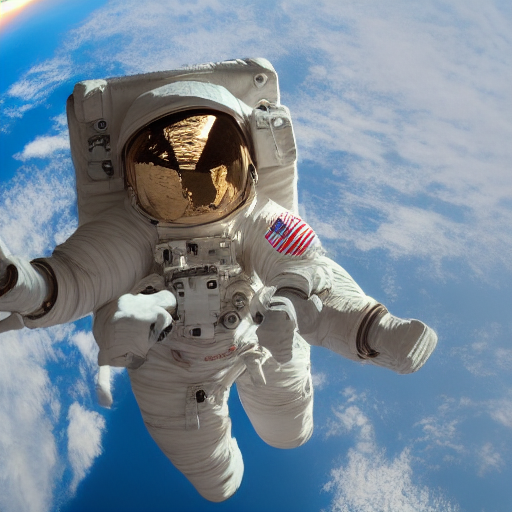

In [17]:
from diffusers import DDIMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
ddim_sched = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

img = render_image("an astronaut flying", vae, unet, tokenizer, text_encoder, ddim_sched, num_steps=15) # Replace the scheduler with our DDIM
vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()

img[0]


In [18]:

!nvidia-smi

Wed Dec 13 00:52:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    36W /  70W |   4305MiB / 15360MiB |     45%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

A full list of components available from the diffusers package can be found here: https://huggingface.co/docs/diffusers/index. Some potential schedulers:
- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py).


Try **at least 3 new combinations** along with different combinations of hyperparameters such as steps, guidance scale, etc.. and write 2-3 paragraphs about what works well, why it seems to work well, and what you're overall best pipeline is. Try a variety of prompts and **include at least 3 comparison images** in your write-up.

Also include **2 images generated using your best technique for each these prompts**:
* "a big bruin bear roaring at a trojan warrior"
* "a person taking a picture of a landscape"
* "a tall building on a busy street".

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/30 [00:00<?, ?it/s]

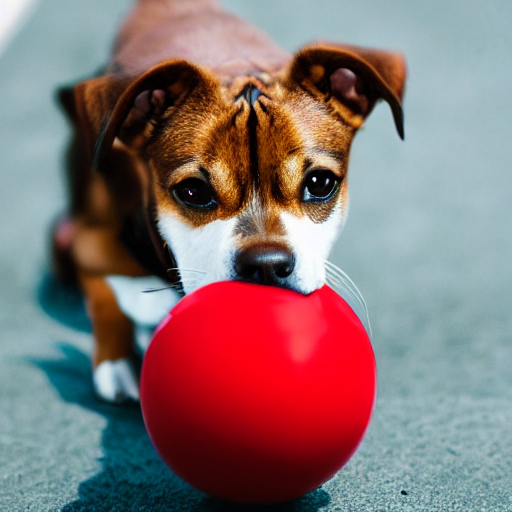

In [19]:
with torch.no_grad():
    torch.cuda.empty_cache()
# Different Scheduler - DPMSolver
# Works PNDM, EulerAncestral just ball, DPMSolverSinglestepScheduler works
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DDIMScheduler, DPMSolverSinglestepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched =  DPMSolverSinglestepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A dog playing with a red ball, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, num_steps=30) # Replace the scheduler with our DDIM

vae = 1

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = 1
text_encoder = 1

# 3. The UNet model for generating the latents.
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()

img[0]


<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/30 [00:00<?, ?it/s]

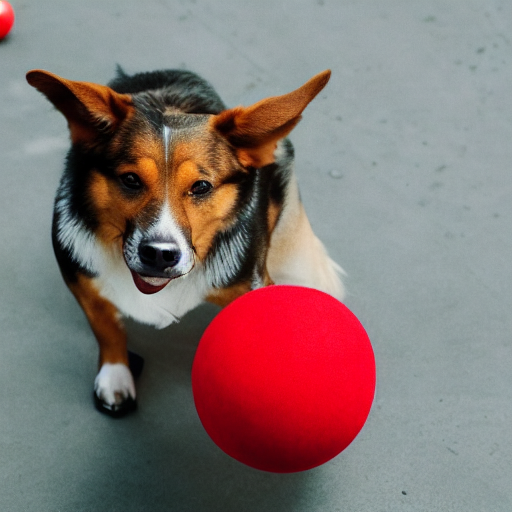

In [20]:
# Different Scheduler - DDIM
with torch.no_grad():
    torch.cuda.empty_cache()
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DDIMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
new_image = render_image("A dog playing with a red ball, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, num_steps=30) # Replace the scheduler with our DDIM


vae = 1

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = 1
text_encoder = 1

# 3. The UNet model for generating the latents.
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()

img[0]

new_image[0]


<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/30 [00:00<?, ?it/s]

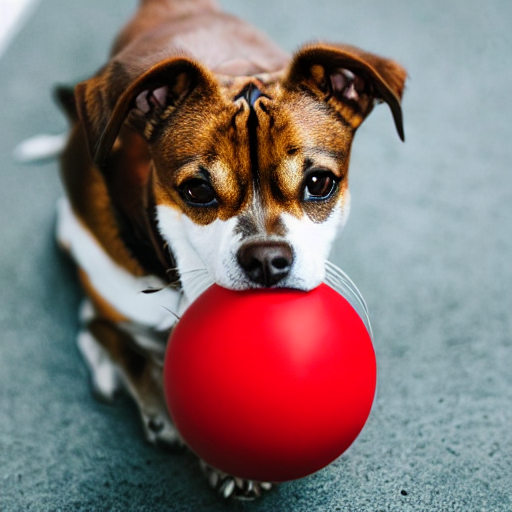

In [21]:
# Different Scheduler - DPMSolverMulti
with torch.no_grad():
    torch.cuda.empty_cache()
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A dog playing with a red ball, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, num_steps=30) # Replace the scheduler with our DDIM


vae = 1

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = 1
text_encoder = 1

# 3. The UNet model for generating the latents.
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()

img[0]




<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

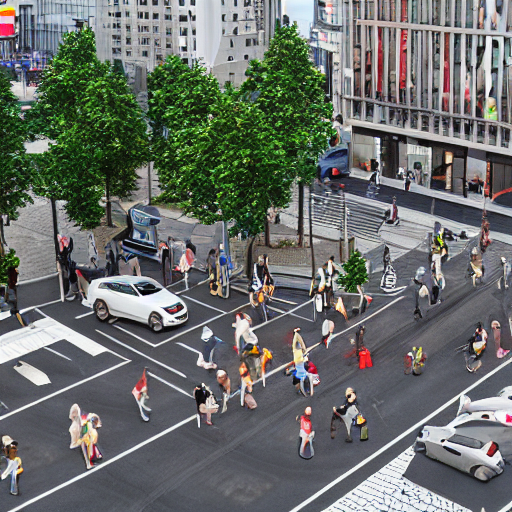

In [22]:
# VAE - Autoencoder
with torch.no_grad():
    torch.cuda.empty_cache()

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A busy street crossing, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, num_steps=50) # Replace the scheduler with our DDIM


vae = 1

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = 1
text_encoder = 1

# 3. The UNet model for generating the latents.
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()


img[0]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.79M [00:00<?, ?B/s]

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

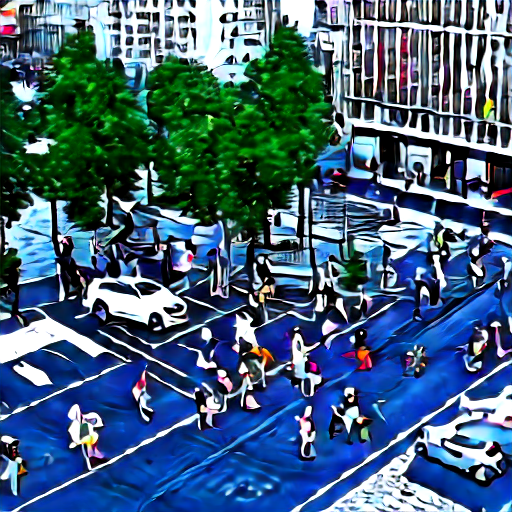

In [23]:
# Different VAE - TinyVAE
with torch.no_grad():
    torch.cuda.empty_cache()
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderTiny, UNet2DConditionModel, PNDMScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderTiny.from_pretrained("madebyollin/taesd")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A busy street crossing, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, num_steps=50) # Replace the scheduler with our DDIM

vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()

img[0]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

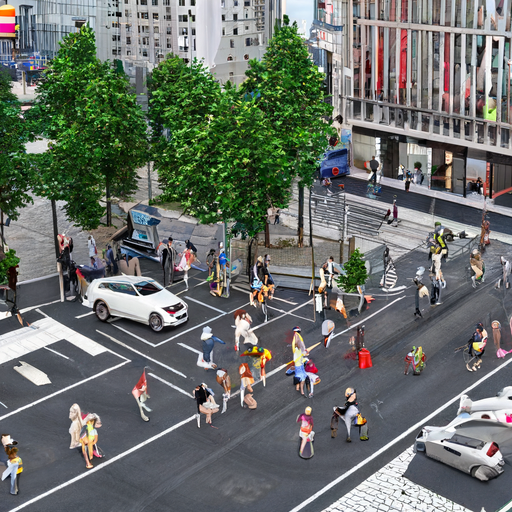

In [24]:
with torch.no_grad():
    torch.cuda.empty_cache()
# Different VAE - AsymmetricAutoencoderVAE

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import ConsistencyDecoderVAE, UNet2DConditionModel, PNDMScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = ConsistencyDecoderVAE.from_pretrained("openai/consistency-decoder")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A busy street crossing, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, num_steps=50) # Replace the scheduler with our DDIM

vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()


img[0]

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/500 [00:00<?, ?it/s]

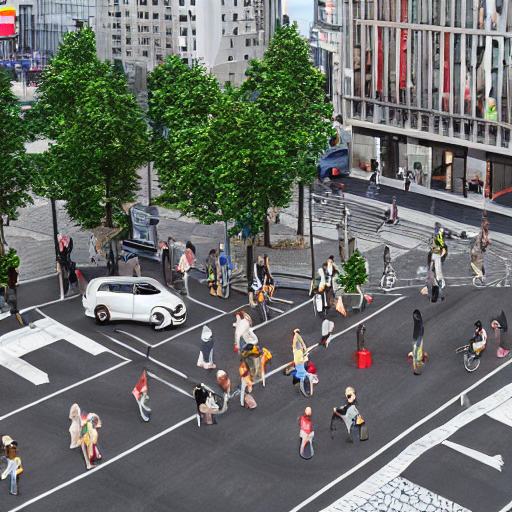

In [25]:

# 500 steps
with torch.no_grad():
    torch.cuda.empty_cache()

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A busy street crossing, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, num_steps=500) # Replace the scheduler with our DDIM

vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()


img[0]

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

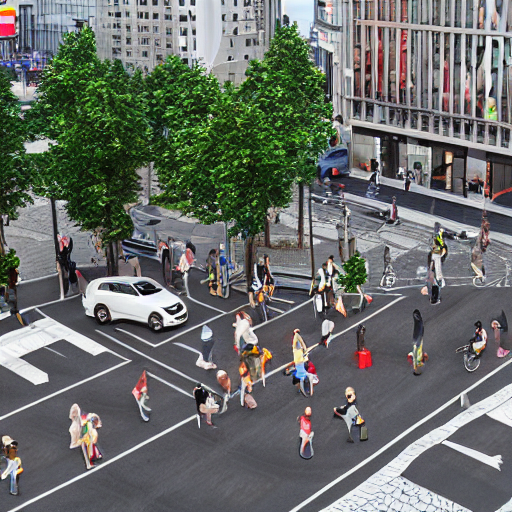

In [26]:
# Guidance 8
with torch.no_grad():
    torch.cuda.empty_cache()

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A busy street crossing, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, guidance_scale=8, num_steps=50) # Replace the scheduler with our DDIM

vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()


img[0]

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

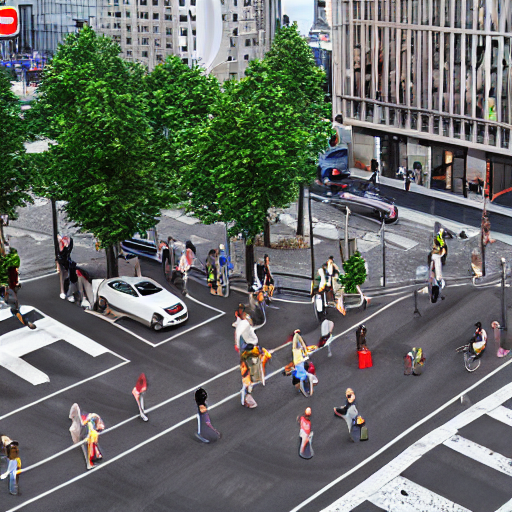

In [27]:
# Guidance 10
with torch.no_grad():
    torch.cuda.empty_cache()

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("A busy street crossing, photorealistic and high definition", vae, unet, tokenizer, text_encoder, sched, guidance_scale=10, num_steps=50) # Replace the scheduler with our DDIM

vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()


img[0]

<ipython-input-14-e6b949a0a152>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

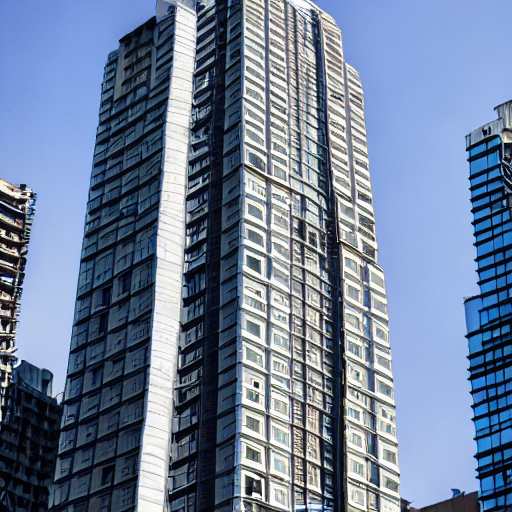

In [28]:
# Guidance 10
with torch.no_grad():
    torch.cuda.empty_cache()

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

sched = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
img = render_image("a tall building on a busy street", vae, unet, tokenizer, text_encoder, sched, guidance_scale=10, num_steps=50, seed=674) # Replace the scheduler with our DDIM

vae = 1
tokenizer = 1
text_encoder = 1
unet = 1
scheduler = 1
with torch.no_grad():
    torch.cuda.empty_cache()


img[0]

In [29]:
!nvidia-smi

Wed Dec 13 01:00:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    41W /  70W |   4305MiB / 15360MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Student Write-up + Images

When comparing the DPMSolverMultistepScheduler to the DPMSolverSingleStepScheduler, we obtain an improved version of the image with the same timesteps, indicating that using multiple steps improves image quality. The image from the Multistep scheduler contains more defined details of the ball, and overall looks less "smooth". Furthermore, DPMSolverMultiStep exceeds the quality of DDIM with better realism on the dog's face. Therefore, we will use DPMSolverMultistepScheduler for the rest of the evaluations.

DPM Single

![](https://drive.google.com/uc?export=view&id=1-Lsxbg_MxjYWcChEYL1Jx-xQquABoT-Q)


DPM Multi

![](https://drive.google.com/uc?export=view&id=17zHvFXV-SC6tBlicLR8dx8iiNBGjRAP4)

Next, I evaluated different VAE configurations. The VAE's evaluated were the AutoEncoderKL, AutoEncoderTiny, and ConsistencyDecoderVAE. AutoEncoderTiny did not perform well on a cityscape, providing the following result, suggesting that compressing it into a smaller latent space may result in loss of too much information.

AutoEncoder Tiny

![](https://drive.google.com/uc?export=view&id=1FIV0RQAvf0BEwitni4wbnpIcPVDGYV3b)

In contrast, there was not a significant different between ConsistencyDecoderVAE and AutoEncoderKL. However, ConsistencyDecoderVAE took a larger amount of memory, so we will utilize AutoEncoderKL as the best one.


AutoEncoderKL

![](https://drive.google.com/uc?export=view&id=1DLFvfficNj6OupiXUU7is5BNeE700ZU9)


ConsistencyDecoderVAE

![](https://drive.google.com/uc?export=view&id=1ozQdmVAXj39XXEHf6x7PT4zo4XdLI97H)

When testing different steps and guidances, I found that there were diminishing returns for increasing the steps to a large number. In fact, increasing to a large number such as 500 created a somewhat distorted image (car). The best step amount with reasonable run time as chosen to be 50. Increasing the guidance marginally created a better quality image, as can be seen in the shape of the car from 8 to 10 guidance.

100 Steps:

![](https://drive.google.com/uc?export=view&id=1f0BThQXBvi1PKqpE4VxSs3H__7Cc2era)


500 Steps:

![](https://drive.google.com/uc?export=view&id=1uS3TcsKIVA2DOQaspdg2oI06e5AdNLoM)


Guidance 8:

![](https://drive.google.com/uc?export=view&id=1uBvpKDsvjynx6SmtP-S55_k5PLTqpVeS)

Guidance 10:

![](https://drive.google.com/uc?export=view&id=1Vw6PFsnuzNk1qUNfJXQIvRZe6m_G36OK)

Ultimately, the best combination used is the DPMSolverMultistepScheduler with AutoEncoderKL, 50 steps and 10 guidance.





Images:


Bruin Bear 1:

![](https://drive.google.com/uc?export=view&id=1SXqs1eiyq-RMyVh7I8hma4Z8acXHk2sl)

Bruin Bear 2:

![](https://drive.google.com/uc?export=view&id=1lVCe_EO8GUoukTtK4AcPCHrQcilaK9Sf)

Landscape 1:

![](https://drive.google.com/uc?export=view&id=1RiL8hl7Agmp-A86x6HMw0ca8WaxpGdsU)

Landscape 2:

![](https://drive.google.com/uc?export=view&id=1YyzcdfPshgY2LJyFmkICASU95aQ-UPwW)

Building 1:

![](https://drive.google.com/uc?export=view&id=1tcwOAuUGhLaE7JkKh6baWOp2oQVi60zH)

Building 2:

![](https://drive.google.com/uc?export=view&id=180677CKr3ubY6E9FD_BNVPDz21y6Go3g)






### Written Questions

1. At the end of the derivation of ELBO from lecture, we are left with two parts:

$$\log{p(x)} = \mathbb{E}_q[\log{\frac{p(x|z)}{q(z|x)}}] + \log{\mathbb{E}_q[\frac{q(z|x)}{p(z|x)}]}$$

* Which of these (left or right), becomes the KL Divergence term?
* Write out the full equation (including the KL divergence term) for what we would want to maximize. Note you can use LaTeX in colab by adding $$ signs before and after the equation.
* Intuitively explain what the KL Divergence term is measuring

Answer:

The term on the *right* becomes the KL divergence term while the term on the left is the ELBO term. The right hand side of the equation simplifies to $E_q[log\frac{p(x|z)}{q(z|x)}] + D_{KL}(q(z|x) || p(z|x))$. By maximizing the ELBO, we minimize the KL divergence term, which reduces the distance between the two distributions $q$ and $p$. This is good as we want $q$ to be a surrogate for the distribution $p$. Intuitively, the KL divergence gives us how similar two distributions are, with a smaller KL divergence indicating higher similarity

2. We've written out part of the derviation for ELBO for a heirarchical VAE/diffusion model below. Identify the mistakes in these steps, if there are any, and write the correct equation. If there are no mistakes, put "No mistakes"

$$\log{p(x)} = \mathbb{E}_q [\log{\frac{p(x, z_{1:T})}{q(z_{1:T}|x)}}]$$

$$\log{p(x)} =  \mathbb{E}_q [\log{\frac{p(z_T) p(x | z_1) \Pi_{t=2}^T p(z_t | z_{t-1})}{q(z_1|x) \Pi_{t=2}^T q(z_{t-1} | z_t)}}]$$

Answer:

The first line should be $$\log{p(x)} >= \mathbb{E}_q [\log{\frac{p(x, z_{1:T})}{q(z_{1:T}|x)}}]$$ instead of equals, since ELBO is the lower bound.

In the second equation, $\Pi_{t=2}^T p(z_t | z_{t-1})$ should be $\Pi_{t=2}^T p(z_{t-1} | z_{t})$ instead since $p$ strives to undo the noising process. Similarly, $q$ in the denominator should be the forward process.

The second eqution should be:

$$\log{p(x)} =  \mathbb{E}_q [\log{\frac{p(z_T) p(x | z_1) \Pi_{t=2}^T p(z_{t-1} | z_{t})}{q(z_1|x) \Pi_{t=2}^T q(z_{t} | z_{t-1})}}]$$

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................